In [1]:
import numpy as np
import pandas as pd
import random
%config InlineBackend.figure_format = 'svg' # Makes the images look nice
%matplotlib inline

import qiskit
# from qiskit.visualization import
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer
from qiskit.tools.visualization import plot_state_city, plot_bloch_multivector, plot_histogram
from qiskit.tools.monitor import job_monitor
from qiskit.quantum_info import state_fidelity, DensityMatrix
# from qiskit.quantum_info.random.utils import random_state
from qiskit.providers.aer import noise

# Tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
# import qiskit.ignis.mitigation.measurement as mc

# readout calibration
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

In [2]:
from qiskit import IBMQ
# loading roel's account
# IBMQ.save_account('30c393d587101bddd683187f32510459f5c95e4d0afdf3da7ba96f18262de522fab6749335cb7504cc72eebf25110567ee03e7ea2ba29b644a3ab9e5a03a56f2')
# IBMQ.active_account() # to check what account is active
ibmq_provider = IBMQ.load_account()        # credentials stored on disk
simulator = ibmq_provider.get_backend('ibmq_qasm_simulator')
simulator_noise = ibmq_provider.get_backend('ibmq_qasm_simulator')
device = ibmq_provider.get_backend('ibmqx2') #ibmq_burlington ibmq_16_melbourne ibmq_ourense
properties = device.properties()
noise_model = noise.device.basic_device_noise_model(properties)
coupling_map = device.configuration().coupling_map
basis_gates = noise_model.basis_gates

C:\Users\Niels\Anaconda3\lib\site-packages\qiskit\providers\aer\noise\device\basic_device_model.py:112: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


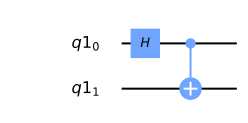

In [3]:
qreg = QuantumRegister(4)
qreg_exp = QuantumRegister(2)
qc_expected = QuantumCircuit(qreg_exp)
qc_expected.h(0)
qc_expected.cx(0,1)
qc_expected.draw(output='mpl')

The expected state is: [0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]


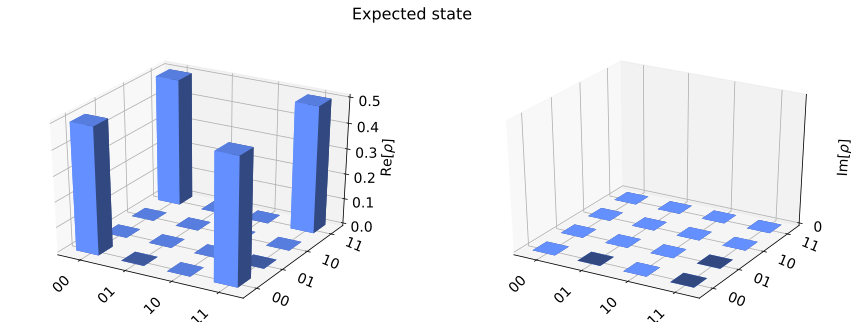

In [4]:
job = qiskit.execute(qc_expected, Aer.get_backend('statevector_simulator'))
psi_expected = job.result().get_statevector(qc_expected)
print('The expected state is:', psi_expected)
plot_state_city(psi_expected, title='Expected state')

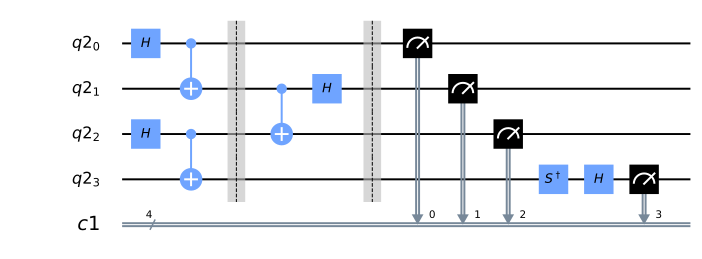

In [5]:
qr = QuantumRegister(4)
cr= ClassicalRegister(4)
qc1 = QuantumCircuit(qr)
qc1.h(0)
qc1.h(2)
qc1.cx(0,1)
qc1.cx(2,3)
qc1.barrier()
qc1.cx(1,2)
qc1.h(1)
qcz=state_tomography_circuits(qc1,[qr])
qct=[qcz[24],qcz[25],qcz[26],qcz[51],qcz[52],qcz[53],qcz[78],qcz[79],qcz[80]]
qct[7].draw(output='mpl')

In [6]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)
cal_circuits, state_labels = complete_meas_cal(qr = qct[8].qregs[0], circlabel = 'measerrormitcal')
cal_job = qiskit.execute(cal_circuits,backend = device,shots = 1024,optimization_level = 0)
job_monitor(cal_job)
calres = cal_job.result()

Job Status: job has successfully run


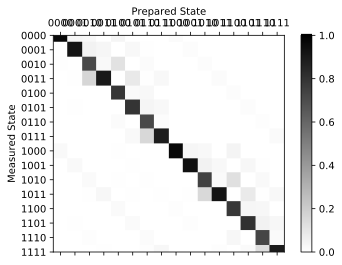

In [7]:
meas_fitter = CompleteMeasFitter(calres, state_labels)
meas_fitter.plot_calibration()
meas_filter = meas_fitter.filter

In [8]:
backends = [simulator,device,0]
result =[0,0,0,0]
bits = [ '0000', '1000', '0001', '1001', '0010', '1010', '0011', '1011','0100', '1100', '0101', '1101', '0110', '1110', '0111', '1111']
paulis = [('X','Z','Z','X'),('Y','Z','Z','X'),('Z','Z','Z','X'),('X','Z','Z','Y'),('Y','Z','Z','Y'),('Z','Z','Z','Y'),('X','Z','Z','Z'),('Y','Z','Z','Z'),('Z','Z','Z','Z')]
basis = ['XX','YX','ZX','XY','YY','ZY','XZ','YZ','ZZ']
for be in range(len(backends)):
    state ={}
    for bas in basis:
        state.update({bas: {'00': 0, '10': 0,'01': 0, '11': 0}})
    state_df = pd.DataFrame(data=[state,state,state,state])
    if be == 0:
        job = qiskit.execute(qct, simulator, shots=8192,noise_model=noise_model, coupling_map=coupling_map, basis_gates=basis_gates)
    if be == 1:
        job = qiskit.execute(qct, device, shots=8192)
        job_monitor(job)
        result[be] = job.result()
    if be == 2:
        tom = StateTomographyFitter(meas_filter.apply(result[be-1]),qct)
    else:
        tom = StateTomographyFitter(job.result(), qct)
    for pauli in paulis:
        for bit in bits:
            if bit not in tom.data[pauli]:
                tom.data[pauli][bit]=0
    for i in range(4):
        for j in range(9):
            state_df.loc[i][basis[j]] = {'00': tom.data[(paulis[j])][bits[4*i]],
                                         '10': tom.data[(paulis[j])][bits[4*i+1]],
                                         '01': tom.data[(paulis[j])][bits[4*i+2]],
                                         '11': tom.data[(paulis[j])][bits[4*i+3]]}
    if be == 0:
        state_sim = state_df
        print('The full state for simulator is', state_df)
    if be == 1:
        state_dev = state_df
        print('The full state for device is', state_df)
        x=0
    if be == 2:
        state_err = state_df
        print('The corrected state for device is', state_df)

The full state for simulator is                                             XX  \
0   {'00': 965, '10': 93, '01': 74, '11': 966}   
1  {'00': 87, '10': 1018, '01': 943, '11': 94}   
2   {'00': 946, '10': 84, '01': 79, '11': 914}   
3   {'00': 70, '10': 891, '01': 886, '11': 82}   

                                             YX  \
0  {'00': 504, '10': 584, '01': 482, '11': 541}   
1  {'00': 549, '10': 542, '01': 549, '11': 516}   
2  {'00': 489, '10': 506, '01': 503, '11': 436}   
3  {'00': 499, '10': 491, '01': 503, '11': 498}   

                                             ZX  \
0  {'00': 547, '10': 574, '01': 525, '11': 515}   
1  {'00': 506, '10': 550, '01': 495, '11': 550}   
2  {'00': 462, '10': 472, '01': 490, '11': 514}   
3  {'00': 502, '10': 484, '01': 500, '11': 506}   

                                             XY  \
0  {'00': 554, '10': 499, '01': 532, '11': 512}   
1  {'00': 515, '10': 531, '01': 541, '11': 547}   
2  {'00': 476, '10': 505, '01': 492, '11': 500}   
3

In [9]:
XXPaul = np.matrix('0,0,0,1;0,0,1,0;0,1,0,0;1,0,0,0')
XYPaul = np.matrix('0,0,0,0-1j;0,0,0+1j,0;0,0-1j,0,0;0+1j,0,0,0')
XZPaul = np.matrix('0,0,1,0;0,0,0,-1;1,0,0,0;0,-1,0,0')
Iden = np.matrix('1,0,0,0;0,1,0,0;0,0,1,0;0,0,0,1')
YXPaul = np.matrix('0,0,0,0-1j;0,0,0-1j,0;0,0+1j,0,0;0+1j,0,0,0')
YYPaul = np.matrix('0,0,0,-1;0,0,1,0;0,1,0,0;-1,0,0,0')
YZPaul = np.matrix('0,0,0-1j,0;0,0,0,0+1j;0+1j,0,0,0;0,0-1j,0,0')
ZXPaul = np.matrix('0,1,0,0;1,0,0,0;0,0,0,-1;0,0,-1,0')
ZYPaul = np.matrix('0,0-1j,0,0;0+1j,0,0,0;0,0,0,0+1j;0,0,0-1j,0')
ZZPaul = np.matrix('1,0,0,0;0,-1,0,0;0,0,-1,0;0,0,0,1')
IXPaul = np.matrix('0,1,0,0;1,0,0,0;0,0,0,1;0,0,1,0')
IYPaul = np.matrix('0,0-1j,0,0;0+1j,0,0,0;0,0,0,0-1j;0,0,0+1j,0')
IZPaul = np.matrix('1,0,0,0;0,-1,0,0;0,0,1,0;0,0,0,-1')
XIPaul = np.matrix('0,0,1,0;0,0,0,1;1,0,0,0;0,1,0,0')
YIPaul = np.matrix('0,0,0-1j,0;0,0,0,0-1j;0+1j,0,0,0;0,0+1j,0,0')
ZIPaul = np.matrix('1,0,0,0;0,1,0,0;0,0,-1,0;0,0,0,-1')

r_exp=np.zeros((4, 9))
ri_exp=np.zeros((4, 9))
ri2_exp=np.zeros((4, 9))
riav_exp=np.zeros((4, 3))
riav2_exp=np.zeros((4, 3))
state_tot=[state_sim,state_dev,state_err]
rhof=[0,0,0,0]
rho2=[0,0,0]
basis2 = ['XX','XY','XZ','YX','YY','YZ','ZX','ZY','ZZ']

for stat in range(len(state_tot)):
    rhof=[0,0,0,0]
    for i in range(4):
        for j in range(9):
            r_exp[i,j] = (state_tot[stat][basis[j]][i]['00']*1 + state_tot[stat][basis[j]][i]['10']*(-1)+state_tot[stat][basis[j]][i]['01']*(-1)+state_tot[stat][basis[j]][i]['11']*1)/(state_tot[stat][basis[j]][i]['00']*1 + state_tot[stat][basis[j]][i]['10']*(1)+state_tot[stat][basis[j]][i]['01']*(1)+state_tot[stat][basis[j]][i]['11']*1)
            ri_exp[i,j] = (state_tot[stat][basis[j]][i]['00']*1 + state_tot[stat][basis[j]][i]['10']*(1)+state_tot[stat][basis[j]][i]['01']*(-1)+state_tot[stat][basis[j]][i]['11']*(-1))/(state_tot[stat][basis[j]][i]['00']*1 + state_tot[stat][basis[j]][i]['10']*(1)+state_tot[stat][basis[j]][i]['01']*(1)+state_tot[stat][basis[j]][i]['11']*1)
            ri2_exp[i,j] = (state_tot[stat][basis2[j]][i]['00']*1 + state_tot[stat][basis2[j]][i]['10']*(-1)+state_tot[stat][basis2[j]][i]['01']*(1)+state_tot[stat][basis2[j]][i]['11']*(-1))/(state_tot[stat][basis2[j]][i]['00']*1 + state_tot[stat][basis2[j]][i]['10']*(1)+state_tot[stat][basis2[j]][i]['01']*(1)+state_tot[stat][basis2[j]][i]['11']*1)
    for i in range(4):
        for j in range(3):
            riav_exp[i,j]=(ri_exp[i,3*j]+ri_exp[i,3*j+1]+ri_exp[i,3*j+2])/3
            riav2_exp[i,j]=(ri2_exp[i,3*j]+ri2_exp[i,3*j+1]+ri2_exp[i,3*j+2])/3
    for i in range(4):
        rhof[i] = (1/4)*(Iden+r_exp[i,0]*XXPaul+r_exp[i,1]*XYPaul+r_exp[i,2]*XZPaul+
                          r_exp[i,3]*YXPaul+r_exp[i,4]*YYPaul+r_exp[i,5]*YZPaul+r_exp[i,6]*ZXPaul+
                          r_exp[i,7]*ZYPaul+r_exp[i,8]*ZZPaul+riav_exp[i,0]*IXPaul+riav2_exp[i,0]*XIPaul+
                          riav_exp[i,1]*IYPaul+riav2_exp[i,1]*YIPaul+riav_exp[i,2]*IZPaul+
                          riav2_exp[i,2]*ZIPaul)
    rho2[stat]=rhof
rho = pd.DataFrame(data=[rho2[0],rho2[1],rho2[2]])
for ind in range(3):
    rho.loc[ind][1] = ZIPaul @ rho.loc[ind][1] @ ZIPaul
    rho.loc[ind][2] = XIPaul @ rho.loc[ind][2] @ XIPaul
    rho.loc[ind][3] = XIPaul @ ZIPaul @ rho.loc[ind][3] @ ZIPaul @ XIPaul
    

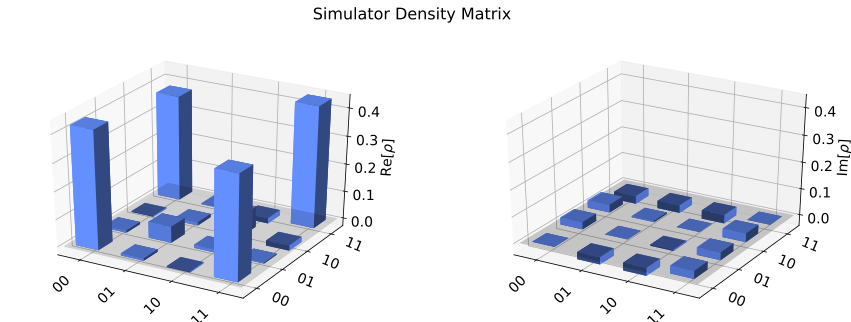

In [10]:
finstate= rho[2][1]
plot_state_city(finstate, title='Simulator Density Matrix')

In [11]:
Fidelity = np.zeros((3,4))
for i in range(3):
    for j in range(4):
        Fidelity[i,j] = state_fidelity(psi_expected, rho[j][i], validate=False)
        
F = np.mean(Fidelity,axis=1)
print('Noisy Simulator Fidelity:', F[0])
print('Device Fidelity:', F[1])
print('Corrected Device Fidelity:', F[2])

Noisy Simulator Fidelity: 0.8803776869899652
Device Fidelity: 0.732585305886199
Corrected Device Fidelity: 0.88533584375778
